In [1]:
import os
import numpy as np
import pandas as pd
import sklearn as sk
import PIL.Image as Image
from IPython import display
import pylab as pl
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from collections import Counter
import operator
import time
from tqdm import tqdm
from skimage.transform import resize, rescale, downscale_local_mean

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1#, l1l2
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


### Functions

In [2]:
def load_sets(sets):
    data = pd.DataFrame()
    for set in sets:
        try:
            set_temp = pd.DataFrame(load_set(set))
            data = data.append(set_temp)
        except:
            print("Set not found.")
        
    return data

def load_set(set):
    if not ".csv" in set:
        csv_file_name = "%s.csv" % set
    else:
        csv_file_name = "%s" % set
    csv_path = "../data/card_data/csv"
    csv_file_path = "%s/%s" % (csv_path, csv_file_name)
        
    return pd.read_csv(csv_file_path)

def get_subtype_df(set, subtype):
    """
        Returns a dataframe containing all cards of the subtype 
        given from the sets given.
    """
    data = set[set["type"].str.contains(subtype,case=False)].drop_duplicates("name")
    return data.sort_values("printings")

def load_images_type_dim(sets, subtype, images_path_):
    pics = []
    x_dim = [20,203]
    for index, set in sets.iterrows():
        images_path = "%s/%s" % (images_path_, set['name'])
        y_dim = [set['Ya'],set['Yb']]
        
        # Load subset type cards from csv lists
        try: #Try to load the given set, if it doesn't exist, pass
            card_names = get_subtype_df(load_set(set['name']),subtype)['name'].values
            for image in card_names:
                try:
                    im_file_name = "%s.full.jpg" % image
                    #print(set, ": ", im_file_name)
                    im_file_path = "%s/%s" % (images_path, im_file_name)
                    #print(im_file_path)
                    image = np.asarray(Image.open(im_file_path))
                    image = resize(image, (310,223), mode='reflect')
                    pics.append(crop_image(image,x_dim,y_dim))
                except OSError:
                    pass
        except:
            pass
    
    return pics

def crop_image(img, cropx, cropy):
    return img[cropy[0]:cropy[1],cropx[0]:cropx[1]]

### Load Card Data

In [3]:
# Path to card csv data, not images
csv_path = "../data/card_data/csv"

# List of all files in the csv directory
#  This is essentially a list of the names of all MTG sets
#  We will loop through all the names of the files and load them into memory
#  to have a single dataframe with every card from every set.
filelist = os.listdir(csv_path)
data_sets = load_sets(filelist).fillna("none")

In [4]:
data_sets

,name,manaCost,cmc,colorIdentity,artist,number,type,text,printings,flavor,layout,multiverseid,power,toughness,rarity,subtypes,types
0,Abolish,{1}{W}{W},3,W,Kev Walker,1,Instant,You may discard a Plains card rather than pay ...,"PCY,DDF","As war raged on, the young mages became more d...",normal,24561,none,none,Uncommon,none,Instant
1,Aura Fracture,{2}{W},3,W,Rebecca Guay,2,Enchantment,Sacrifice a land: Destroy target enchantment.,PCY,Jamuraa's rhystic mages treat magic as their g...,normal,24560,none,none,Common,none,Enchantment
2,Avatar of Hope,{6}{W}{W},8,W,rk post,3,Creature — Avatar,"If you have 3 or less life, Avatar of Hope cos...","pPRE,PCY,8ED",none,normal,24564,4,9,Rare,Avatar,Creature
3,Blessed Wind,{7}{W}{W},9,W,Anthony S. Waters,4,Sorcery,Target player's life total becomes 20.,PCY,"""The fourth wind of ascension is Anointer, dei...",normal,24569,none,none,Rare,none,Sorcery
4,Celestial Convergence,{2}{W}{W},4,W,Ray Lago,5,Enchantment,Celestial Convergence enters the battlefield w...,PCY,none,normal,24567,none,none,Rare,none,Enchantment
5,Diving Griffin,{1}{W}{W},3,W,John Howe,6,Creature — Griffin,"Flying, vigilance","PCY,8ED",To outrace the griffin\n—Kipamu expression mea...,normal,24548,2,2,Common,Griffin,Creature
6,Entangler,{2}{W}{W},4,W,D. Alexander Gregory,7,Enchantment — Aura,Enchant creature\nEnchanted creature can block...,PCY,"""Tell me again,"" said Latulla, raising her fis...",normal,24557,none,none,Uncommon,Aura,Enchantment
7,Excise,{X}{W},1,W,Joel Biske,8,Instant,Exile target attacking creature unless its con...,PCY,"""Creation is no great feat. Anything you make,...",normal,24553,none,none,Common,none,Instant
8,Flowering Field,{1}{W},2,W,Jeff Miracola,9,Enchantment — Aura,"Enchant land\nEnchanted land has ""{T}: Prevent...",PCY,"Some lands are soothing, and their peace can b...",normal,24552,none,none,Uncommon,Aura,Enchantment
9,Glittering Lion,{2}{W},3,W,Don Hazeltine,10,Creature — Cat,Prevent all damage that would be dealt to Glit...,PCY,none,normal,24558,2,2,Uncommon,Cat,Creature


### Examine Specific Card Type
We will be looking at the elf creature subtype. Filtering on all cards that contain the subtype elf, so we have a dataframe that contains only elves.

In [5]:
# Filter based on type containing 'elf'
card_type = "elf"
elves_all = get_subtype_df(data_sets, card_type)
# Get all sets that contain elves
elf_sets = elves_all["printings"].values

print("Number of unique %s cards: %d" %(card_type, elves_all.shape[0]))
elves_all

Number of unique elf cards: 305


,name,manaCost,cmc,colorIdentity,artist,number,type,text,printings,flavor,layout,multiverseid,power,toughness,rarity,subtypes,types
98,Viridian Lorebearers,{3}{G},4,G,Darrell Riche,99,Creature — Elf Shaman,"{3}{G}, {T}: Target creature gets +X/+X until ...",5DN,A small band of elves pledged many years ago t...,normal,50188,3,3,Uncommon,"Elf,Shaman",Creature
99,Viridian Scout,{3}{G},4,G,Daren Bader,100,Creature — Elf Warrior Scout,"{2}{G}, Sacrifice Viridian Scout: Viridian Sco...",5DN,They know a hoverguard's only blind spot is di...,normal,73583,1,2,Common,"Elf,Warrior,Scout",Creature
88,Joiner Adept,{1}{G},2,G,Christopher Rush,89,Creature — Elf Druid,"Lands you control have ""{T}: Add one mana of a...","5DN,10E",A talented apprentice makes all things. The ma...,normal,72928,2,1,Rare,"Elf,Druid",Creature
123,Behemoth's Herald,{G},1,G,Paolo Parente,124,Creature — Elf Shaman,"{2}{G}, {T}, Sacrifice a red creature, a green...",ALA,"""Mine is an insatiable god, with appetites as ...",normal,175263,1,1,Uncommon,"Elf,Shaman",Creature
126,Cylian Elf,{1}{G},2,G,Steve Prescott,127,Creature — Elf Scout,none,ALA,From her sunsail tent high above the forest fl...,normal,174935,2,2,Common,"Elf,Scout",Creature
127,Druid of the Anima,{1}{G},2,"G,R,W",Jim Murray,128,Creature — Elf Druid,"{T}: Add {R}, {G}, or {W} to your mana pool.",ALA,Although the Anima herself remains at the Sace...,normal,174903,1,1,Common,"Elf,Druid",Creature
132,Godtoucher,{3}{G},4,"G,W",Jesper Ejsing,133,Creature — Elf Cleric,"{1}{W}, {T}: Prevent all damage that would be ...",ALA,"""Gargantuans die not in moments but in moons. ...",normal,174822,2,2,Common,"Elf,Cleric",Creature
134,Keeper of Progenitus,{3}{G},4,G,Kev Walker,135,Creature — Elf Druid,"Whenever a player taps a Mountain, Forest, or ...",ALA,He watches over the valley where Progenitus sl...,normal,175033,1,3,Rare,"Elf,Druid",Creature
145,Sacellum Godspeaker,{2}{G},3,G,Wayne Reynolds,146,Creature — Elf Druid,{T}: Reveal any number of creature cards with ...,ALA,Her connection to the gargantuans puts her in ...,normal,174828,2,2,Rare,"Elf,Druid",Creature
178,Mayael the Anima,{R}{G}{W},3,"W,R,G",Jason Chan,179,Legendary Creature — Elf Shaman,"{3}{R}{G}{W}, {T}: Look at the top five cards ...","ALA,C13",The sacred Anima's eyes are blind to all but t...,normal,175058,2,3,Mythic Rare,"Elf,Shaman",Creature


### Load Images
Load images from the sets that have been pre-sized and examined.

All sets in the `/data/images/set_dimensions_big.csv` are legitimate, and have had their card art properly bordered.

In [6]:
# Load all image directory names
images_path = "../data/images/sets"
sets = os.listdir(images_path)

# Load preconfigured set_dimensions file
sets_dimensions = pd.read_csv("../data/images/set_dimensions_big.csv",header=0)

In [7]:
subtype = 'elf'

pics = load_images_type_dim(sets_dimensions, subtype, images_path)
print(len(pics))
print("Number of %s card images: %d" %(subtype, len(pics)))
print("Dimensions of images:", pics[0].shape)

# for image in pics:
#     plt.figure()
#     plt.imshow(image)

435
Number of elf card images: 435
Dimensions of images: (135, 183, 3)


In [9]:
# Explore image data
pics = np.asarray(pics)
pics.shape

(435, 135, 183, 3)

### Set up train/test split

In [10]:
# Create labels. Half the data will be assigned 0, and half 1. 
# These labels won't really be used, but they're there just in
# case we need them. GANs are more unsupervised anyway.
labels = np.zeros(pics.shape[0],dtype=np.int8)
# Assign half of the labels to 1
labels[int(labels.shape[0]/2):]=1

indices = np.random.permutation(pics.shape[0])

train_split = 0.6
rand_seed = 42
X_train, X_test, y_train, y_test = train_test_split(
        pics, indices, test_size=1-train_split, random_state = rand_seed)


### Set Up GAN

In [11]:
def initNormal(shape, name):
    return initializers.normal(shape, scale=0.02, name=name)

randomDim = 100

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

In [12]:
# Generator inputs
print("Picture shape:", pics.shape)
# In = 100
# Out = dim x dim x depth
depth = 64 + 64 + 64 + 64
dim = ()

Picture shape: (435, 135, 183, 3)


#### Generator

In [13]:
generator = Sequential()
generator.add(Dense(256, input_dim=randomDim))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(74115, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [16]:
gen = Sequential()
gen.add(Dense(256, input_dim=randomDim))
generator.add(LeakyReLU(0.2))
gen.add(Dropout(dropout))


In [15]:
# Discriminator input information
print("Picture shape:", pics.shape)
# In = 135 x 183 x 3
# Out = 33 x 45 x 3
depth = 64
dropout = 0.4

Picture shape: (435, 135, 183, 3)


#### Discriminator

In [17]:
# Dense network
#model.add(Dense(nb_neurons, activation=activation, input_shape=(input_shape,)))
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=74115))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [18]:
# Convolutional network
disc = Sequential()
# disc.add(Conv2D(128, 5, subsample=(2,2), input_dim=74115))
disc.add(Conv2D(64, 5, strides=(2,2), input_shape=(135, 183, 3), padding='same'))
disc.add(LeakyReLU(0.2))
disc.add(Dropout(0.3))
disc.add(Conv2D(128, 5, padding='same'))
disc.add(LeakyReLU(0.2))
disc.add(Dropout(0.3))
disc.add(Conv2D(128, 3, padding='same'))
disc.add(LeakyReLU(0.2))
disc.add(Flatten())
disc.add(Dense(1, activation='sigmoid'))
disc.compile(loss='binary_crossentropy', optimizer=adam)

#### Combined Network

In [19]:
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, output = ganOutput)
gan.compile(loss='binary_crossentropy',optimizer=adam)

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """


#### Plot loss from each batch

In [20]:
dLosses = []
gLosses = []

def plotLoss(epoch):
    plt.figure(figsize=(10,8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../data/generated_images/v1/gan_loss_epoch_%d.png' % epoch)

#### Create a wall of generated images

In [21]:
def plotGeneratedImages(epoch, examples=9, dim=(3,3), figsize=(5,5)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 135, 183, 3)
    
#     plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest')
        plt.axis('off')
    #plt.tight_layout()
    # Write save file location later
    plt.savefig('images')

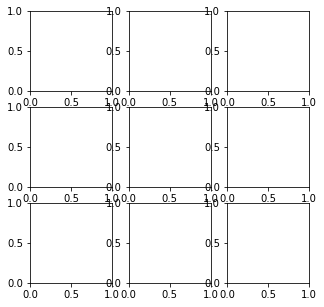

In [22]:
dim=(3,3)
plt.figure(figsize=(5,5))
for i in range(dim[0]*dim[1]):
    plt.subplot(dim[0], dim[1], i+1)

#### Save the generator and discriminator networks (and weights) for later use

In [24]:
def saveModels(epoch):
    generator.save('../models/v1/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('../models/v1/gan_discriminator_epoch_%d.h5' % epoch)

### Trainer

In [25]:
def train(X_train, epochs = 1, batchSize = 4):
    batchCount = int(X_train.shape[0] / batchSize)
    print("X_train shape:", X_train.shape[0])
    print('Epochs', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch', batchCount)
    
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(0, batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]
            
            # Reshape imageBatch (might not be correct)
            imageBatch = imageBatch.reshape(batchSize, imageBatch.shape[1]
                                            *imageBatch.shape[2]*imageBatch.shape[3])
            
            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print (np.shape(imageBatch), np.shape(generatedImages)
            print('imageBatch shape', imageBatch.shape)
            print('generatedImages shape', generatedImages.shape)
            X = np.concatenate([imageBatch, generatedImages])
            
            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.0
            
            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
            
            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
            
        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        
        if e==1 or e % 20 == 0:
            plotGeneratedImages(e)
            saveModels(e)
            
    # plot losses from every epoch
    plotLoss(e)

  0%|          | 0/65 [00:00<?, ?it/s]

X_train shape: 261
Epochs 200
Batch size: 4
Batches per epoch 65
--------------- Epoch 1 ---------------
imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  2%|▏         | 1/65 [00:07<07:47,  7.31s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  3%|▎         | 2/65 [00:11<06:42,  6.39s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  5%|▍         | 3/65 [00:15<05:54,  5.72s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  6%|▌         | 4/65 [00:20<05:25,  5.33s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  8%|▊         | 5/65 [00:24<05:03,  5.06s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  9%|▉         | 6/65 [00:28<04:43,  4.80s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 11%|█         | 7/65 [00:32<04:26,  4.59s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 12%|█▏        | 8/65 [00:36<04:13,  4.45s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 14%|█▍        | 9/65 [00:41<04:03,  4.35s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 15%|█▌        | 10/65 [00:45<03:55,  4.29s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 17%|█▋        | 11/65 [00:49<03:48,  4.24s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 18%|█▊        | 12/65 [00:53<03:44,  4.24s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 20%|██        | 13/65 [00:57<03:42,  4.27s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 22%|██▏       | 14/65 [01:02<03:38,  4.27s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 23%|██▎       | 15/65 [01:06<03:32,  4.25s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 25%|██▍       | 16/65 [01:10<03:26,  4.22s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 26%|██▌       | 17/65 [01:14<03:22,  4.23s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 28%|██▊       | 18/65 [01:19<03:20,  4.26s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 29%|██▉       | 19/65 [01:23<03:16,  4.27s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 31%|███       | 20/65 [01:27<03:11,  4.24s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 32%|███▏      | 21/65 [01:32<03:10,  4.33s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 34%|███▍      | 22/65 [01:36<03:05,  4.32s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 35%|███▌      | 23/65 [01:40<02:59,  4.28s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 37%|███▋      | 24/65 [01:44<02:53,  4.24s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 38%|███▊      | 25/65 [01:48<02:49,  4.23s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 40%|████      | 26/65 [01:53<02:44,  4.21s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 42%|████▏     | 27/65 [01:57<02:38,  4.18s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 43%|████▎     | 28/65 [02:01<02:34,  4.17s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 45%|████▍     | 29/65 [02:05<02:29,  4.15s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 46%|████▌     | 30/65 [02:09<02:27,  4.20s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 48%|████▊     | 31/65 [02:14<02:25,  4.27s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 49%|████▉     | 32/65 [02:18<02:20,  4.25s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 51%|█████     | 33/65 [02:22<02:17,  4.30s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 52%|█████▏    | 34/65 [02:27<02:12,  4.29s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 54%|█████▍    | 35/65 [02:31<02:07,  4.25s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 55%|█████▌    | 36/65 [02:35<02:02,  4.22s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 57%|█████▋    | 37/65 [02:39<01:57,  4.20s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 58%|█████▊    | 38/65 [02:43<01:52,  4.18s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 60%|██████    | 39/65 [02:48<01:50,  4.26s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 62%|██████▏   | 40/65 [02:52<01:48,  4.34s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 63%|██████▎   | 41/65 [02:57<01:44,  4.37s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 65%|██████▍   | 42/65 [03:01<01:42,  4.44s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 66%|██████▌   | 43/65 [03:06<01:38,  4.50s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 68%|██████▊   | 44/65 [03:10<01:35,  4.53s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 69%|██████▉   | 45/65 [03:15<01:29,  4.49s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 71%|███████   | 46/65 [03:19<01:24,  4.47s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 72%|███████▏  | 47/65 [03:24<01:19,  4.43s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 74%|███████▍  | 48/65 [03:28<01:13,  4.35s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 75%|███████▌  | 49/65 [03:32<01:08,  4.31s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 77%|███████▋  | 50/65 [03:36<01:03,  4.25s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 78%|███████▊  | 51/65 [03:40<00:59,  4.27s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 80%|████████  | 52/65 [03:45<00:56,  4.35s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 82%|████████▏ | 53/65 [03:49<00:52,  4.37s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 83%|████████▎ | 54/65 [03:54<00:48,  4.41s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 85%|████████▍ | 55/65 [03:58<00:44,  4.44s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 86%|████████▌ | 56/65 [04:03<00:39,  4.44s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 88%|████████▊ | 57/65 [04:07<00:35,  4.41s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 89%|████████▉ | 58/65 [04:11<00:30,  4.38s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 91%|█████████ | 59/65 [04:16<00:26,  4.34s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 92%|█████████▏| 60/65 [04:20<00:21,  4.32s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 94%|█████████▍| 61/65 [04:25<00:17,  4.40s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 95%|█████████▌| 62/65 [04:29<00:13,  4.46s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 97%|█████████▋| 63/65 [04:33<00:08,  4.34s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 98%|█████████▊| 64/65 [04:37<00:04,  4.27s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  0%|          | 0/65 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------
imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  2%|▏         | 1/65 [00:04<04:32,  4.26s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  3%|▎         | 2/65 [00:08<04:24,  4.21s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  5%|▍         | 3/65 [00:12<04:13,  4.09s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  6%|▌         | 4/65 [00:16<04:07,  4.05s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  8%|▊         | 5/65 [00:20<04:00,  4.01s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  9%|▉         | 6/65 [00:23<03:51,  3.92s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 11%|█         | 7/65 [00:27<03:44,  3.87s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 12%|█▏        | 8/65 [00:31<03:34,  3.76s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 14%|█▍        | 9/65 [00:34<03:30,  3.76s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 15%|█▌        | 10/65 [00:38<03:27,  3.77s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 17%|█▋        | 11/65 [00:42<03:25,  3.81s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 18%|█▊        | 12/65 [00:46<03:18,  3.75s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 20%|██        | 13/65 [00:49<03:12,  3.71s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 22%|██▏       | 14/65 [00:53<03:11,  3.76s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 23%|██▎       | 15/65 [00:57<03:10,  3.80s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 25%|██▍       | 16/65 [01:01<03:05,  3.78s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 26%|██▌       | 17/65 [01:04<03:00,  3.75s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 28%|██▊       | 18/65 [01:08<02:56,  3.76s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 29%|██▉       | 19/65 [01:12<02:51,  3.73s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 31%|███       | 20/65 [01:15<02:46,  3.71s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 32%|███▏      | 21/65 [01:19<02:43,  3.71s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 34%|███▍      | 22/65 [01:23<02:38,  3.68s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 35%|███▌      | 23/65 [01:26<02:34,  3.67s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 37%|███▋      | 24/65 [01:30<02:30,  3.66s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 38%|███▊      | 25/65 [01:34<02:27,  3.68s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 40%|████      | 26/65 [01:37<02:23,  3.69s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 42%|████▏     | 27/65 [01:41<02:19,  3.68s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 43%|████▎     | 28/65 [01:45<02:17,  3.71s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 45%|████▍     | 29/65 [01:49<02:13,  3.70s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 46%|████▌     | 30/65 [01:52<02:08,  3.67s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 48%|████▊     | 31/65 [01:56<02:03,  3.64s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 49%|████▉     | 32/65 [01:59<01:58,  3.61s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 51%|█████     | 33/65 [02:03<01:54,  3.59s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 52%|█████▏    | 34/65 [02:06<01:50,  3.57s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 54%|█████▍    | 35/65 [02:10<01:46,  3.57s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 55%|█████▌    | 36/65 [02:14<01:43,  3.57s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 57%|█████▋    | 37/65 [02:17<01:39,  3.54s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 58%|█████▊    | 38/65 [02:21<01:35,  3.55s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 60%|██████    | 39/65 [02:24<01:32,  3.55s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 62%|██████▏   | 40/65 [02:28<01:29,  3.56s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 63%|██████▎   | 41/65 [02:31<01:26,  3.61s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 65%|██████▍   | 42/65 [02:35<01:23,  3.62s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 66%|██████▌   | 43/65 [02:39<01:19,  3.60s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 68%|██████▊   | 44/65 [02:42<01:15,  3.58s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 69%|██████▉   | 45/65 [02:46<01:10,  3.54s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 71%|███████   | 46/65 [02:49<01:06,  3.48s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 72%|███████▏  | 47/65 [02:53<01:03,  3.55s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 74%|███████▍  | 48/65 [02:57<01:02,  3.66s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 75%|███████▌  | 49/65 [03:00<00:59,  3.71s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 77%|███████▋  | 50/65 [03:04<00:55,  3.73s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 78%|███████▊  | 51/65 [03:08<00:51,  3.71s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 80%|████████  | 52/65 [03:11<00:47,  3.65s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 82%|████████▏ | 53/65 [03:15<00:43,  3.61s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 83%|████████▎ | 54/65 [03:18<00:39,  3.61s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 85%|████████▍ | 55/65 [03:22<00:35,  3.60s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 86%|████████▌ | 56/65 [03:26<00:32,  3.60s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 88%|████████▊ | 57/65 [03:29<00:28,  3.60s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 89%|████████▉ | 58/65 [03:33<00:25,  3.58s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 91%|█████████ | 59/65 [03:36<00:21,  3.55s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 92%|█████████▏| 60/65 [03:40<00:17,  3.59s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 94%|█████████▍| 61/65 [03:44<00:14,  3.62s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 95%|█████████▌| 62/65 [03:47<00:10,  3.65s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 97%|█████████▋| 63/65 [03:51<00:07,  3.68s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 98%|█████████▊| 64/65 [03:55<00:03,  3.68s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  0%|          | 0/65 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------
imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  2%|▏         | 1/65 [00:03<03:58,  3.73s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  3%|▎         | 2/65 [00:07<03:53,  3.71s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  5%|▍         | 3/65 [00:11<03:49,  3.70s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  6%|▌         | 4/65 [00:14<03:45,  3.69s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  8%|▊         | 5/65 [00:18<03:40,  3.67s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  9%|▉         | 6/65 [00:21<03:35,  3.65s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 11%|█         | 7/65 [00:25<03:34,  3.70s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 12%|█▏        | 8/65 [00:29<03:29,  3.67s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 14%|█▍        | 9/65 [00:32<03:23,  3.64s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 15%|█▌        | 10/65 [00:36<03:19,  3.62s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 17%|█▋        | 11/65 [00:40<03:16,  3.64s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 18%|█▊        | 12/65 [00:43<03:09,  3.57s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 20%|██        | 13/65 [00:47<03:06,  3.58s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 22%|██▏       | 14/65 [00:50<03:03,  3.60s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 23%|██▎       | 15/65 [00:54<03:01,  3.63s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 25%|██▍       | 16/65 [00:58<02:58,  3.64s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 26%|██▌       | 17/65 [01:01<02:52,  3.60s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 28%|██▊       | 18/65 [01:05<02:48,  3.59s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 29%|██▉       | 19/65 [01:08<02:44,  3.57s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 31%|███       | 20/65 [01:12<02:39,  3.55s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 32%|███▏      | 21/65 [01:16<02:38,  3.60s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 34%|███▍      | 22/65 [01:19<02:34,  3.60s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 35%|███▌      | 23/65 [01:23<02:32,  3.62s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 37%|███▋      | 24/65 [01:27<02:29,  3.65s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 38%|███▊      | 25/65 [01:30<02:25,  3.63s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 40%|████      | 26/65 [01:34<02:20,  3.60s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 42%|████▏     | 27/65 [01:37<02:17,  3.63s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 43%|████▎     | 28/65 [01:41<02:16,  3.69s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 45%|████▍     | 29/65 [01:45<02:12,  3.69s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 46%|████▌     | 30/65 [01:48<02:06,  3.62s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 48%|████▊     | 31/65 [01:52<02:01,  3.58s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 49%|████▉     | 32/65 [01:55<01:56,  3.54s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 51%|█████     | 33/65 [01:59<01:53,  3.53s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 52%|█████▏    | 34/65 [02:02<01:49,  3.53s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 54%|█████▍    | 35/65 [02:06<01:46,  3.54s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 55%|█████▌    | 36/65 [02:10<01:44,  3.61s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 57%|█████▋    | 37/65 [02:13<01:41,  3.64s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 58%|█████▊    | 38/65 [02:17<01:38,  3.65s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 60%|██████    | 39/65 [02:21<01:34,  3.65s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 62%|██████▏   | 40/65 [02:24<01:31,  3.67s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 63%|██████▎   | 41/65 [02:28<01:28,  3.69s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 65%|██████▍   | 42/65 [02:32<01:24,  3.68s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 66%|██████▌   | 43/65 [02:35<01:19,  3.63s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 68%|██████▊   | 44/65 [02:39<01:15,  3.62s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 69%|██████▉   | 45/65 [02:42<01:11,  3.59s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 71%|███████   | 46/65 [02:46<01:07,  3.57s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 72%|███████▏  | 47/65 [02:49<01:03,  3.54s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 74%|███████▍  | 48/65 [02:53<01:00,  3.55s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 75%|███████▌  | 49/65 [02:56<00:56,  3.54s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 77%|███████▋  | 50/65 [03:00<00:52,  3.53s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 78%|███████▊  | 51/65 [03:04<00:49,  3.53s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 80%|████████  | 52/65 [03:07<00:45,  3.51s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 82%|████████▏ | 53/65 [03:11<00:42,  3.51s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 83%|████████▎ | 54/65 [03:14<00:38,  3.52s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 85%|████████▍ | 55/65 [03:18<00:35,  3.52s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 86%|████████▌ | 56/65 [03:21<00:32,  3.56s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 88%|████████▊ | 57/65 [03:25<00:29,  3.63s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 89%|████████▉ | 58/65 [03:29<00:25,  3.61s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 91%|█████████ | 59/65 [03:32<00:21,  3.57s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 92%|█████████▏| 60/65 [03:36<00:17,  3.54s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 94%|█████████▍| 61/65 [03:39<00:14,  3.56s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 95%|█████████▌| 62/65 [03:43<00:10,  3.53s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 97%|█████████▋| 63/65 [03:46<00:07,  3.51s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 98%|█████████▊| 64/65 [03:50<00:03,  3.52s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  0%|          | 0/65 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------
imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  2%|▏         | 1/65 [00:03<03:46,  3.53s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  3%|▎         | 2/65 [00:07<03:41,  3.51s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  5%|▍         | 3/65 [00:10<03:37,  3.50s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  6%|▌         | 4/65 [00:13<03:32,  3.48s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  8%|▊         | 5/65 [00:17<03:30,  3.51s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  9%|▉         | 6/65 [00:21<03:27,  3.52s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 11%|█         | 7/65 [00:24<03:22,  3.50s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 12%|█▏        | 8/65 [00:28<03:20,  3.51s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 14%|█▍        | 9/65 [00:31<03:17,  3.53s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 15%|█▌        | 10/65 [00:35<03:12,  3.50s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 17%|█▋        | 11/65 [00:38<03:09,  3.50s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 18%|█▊        | 12/65 [00:42<03:07,  3.54s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 20%|██        | 13/65 [00:45<03:04,  3.55s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 22%|██▏       | 14/65 [00:49<02:58,  3.51s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 23%|██▎       | 15/65 [00:52<02:54,  3.50s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 25%|██▍       | 16/65 [00:56<02:52,  3.51s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 26%|██▌       | 17/65 [00:59<02:46,  3.48s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 28%|██▊       | 18/65 [01:03<02:47,  3.56s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 29%|██▉       | 19/65 [01:07<02:46,  3.63s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 31%|███       | 20/65 [01:10<02:41,  3.58s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 32%|███▏      | 21/65 [01:14<02:36,  3.56s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 34%|███▍      | 22/65 [01:17<02:28,  3.45s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 35%|███▌      | 23/65 [01:20<02:21,  3.37s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 37%|███▋      | 24/65 [01:23<02:16,  3.33s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 38%|███▊      | 25/65 [01:26<02:10,  3.27s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 40%|████      | 26/65 [01:29<02:05,  3.21s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 42%|████▏     | 27/65 [01:32<02:00,  3.17s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 43%|████▎     | 28/65 [01:36<01:56,  3.16s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 45%|████▍     | 29/65 [01:39<01:52,  3.13s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 46%|████▌     | 30/65 [01:42<01:49,  3.13s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 48%|████▊     | 31/65 [01:45<01:46,  3.12s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 49%|████▉     | 32/65 [01:48<01:44,  3.15s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 51%|█████     | 33/65 [01:51<01:40,  3.14s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 52%|█████▏    | 34/65 [01:54<01:37,  3.14s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 54%|█████▍    | 35/65 [01:58<01:36,  3.22s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 55%|█████▌    | 36/65 [02:01<01:34,  3.25s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 57%|█████▋    | 37/65 [02:04<01:31,  3.28s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 58%|█████▊    | 38/65 [02:08<01:27,  3.25s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 60%|██████    | 39/65 [02:11<01:24,  3.24s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 62%|██████▏   | 40/65 [02:14<01:20,  3.23s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 63%|██████▎   | 41/65 [02:17<01:16,  3.20s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 65%|██████▍   | 42/65 [02:20<01:12,  3.17s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 66%|██████▌   | 43/65 [02:23<01:09,  3.15s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 68%|██████▊   | 44/65 [02:26<01:05,  3.13s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 69%|██████▉   | 45/65 [02:30<01:02,  3.12s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 71%|███████   | 46/65 [02:33<00:59,  3.12s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 72%|███████▏  | 47/65 [02:36<00:55,  3.10s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 74%|███████▍  | 48/65 [02:39<00:52,  3.11s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 75%|███████▌  | 49/65 [02:42<00:49,  3.10s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 77%|███████▋  | 50/65 [02:45<00:46,  3.10s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 78%|███████▊  | 51/65 [02:48<00:43,  3.10s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 80%|████████  | 52/65 [02:51<00:40,  3.08s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 82%|████████▏ | 53/65 [02:54<00:36,  3.08s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 83%|████████▎ | 54/65 [02:57<00:33,  3.07s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 85%|████████▍ | 55/65 [03:00<00:30,  3.08s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 86%|████████▌ | 56/65 [03:04<00:27,  3.10s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 88%|████████▊ | 57/65 [03:07<00:25,  3.13s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 89%|████████▉ | 58/65 [03:10<00:21,  3.13s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 91%|█████████ | 59/65 [03:13<00:18,  3.12s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 92%|█████████▏| 60/65 [03:16<00:15,  3.14s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 94%|█████████▍| 61/65 [03:19<00:12,  3.14s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 95%|█████████▌| 62/65 [03:22<00:09,  3.13s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 97%|█████████▋| 63/65 [03:26<00:06,  3.18s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 98%|█████████▊| 64/65 [03:29<00:03,  3.16s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  0%|          | 0/65 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------
imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  2%|▏         | 1/65 [00:03<03:19,  3.12s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  3%|▎         | 2/65 [00:06<03:16,  3.12s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  5%|▍         | 3/65 [00:09<03:15,  3.15s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  6%|▌         | 4/65 [00:12<03:11,  3.14s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  8%|▊         | 5/65 [00:15<03:07,  3.13s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  9%|▉         | 6/65 [00:18<03:04,  3.12s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 11%|█         | 7/65 [00:21<03:01,  3.13s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 12%|█▏        | 8/65 [00:25<02:57,  3.12s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 14%|█▍        | 9/65 [00:28<02:53,  3.11s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 15%|█▌        | 10/65 [00:31<02:50,  3.10s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 17%|█▋        | 11/65 [00:34<02:47,  3.11s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 18%|█▊        | 12/65 [00:37<02:44,  3.10s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 20%|██        | 13/65 [00:40<02:41,  3.10s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 22%|██▏       | 14/65 [00:43<02:37,  3.09s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 23%|██▎       | 15/65 [00:46<02:34,  3.08s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 25%|██▍       | 16/65 [00:49<02:31,  3.09s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 26%|██▌       | 17/65 [00:52<02:30,  3.14s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 28%|██▊       | 18/65 [00:56<02:27,  3.14s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 29%|██▉       | 19/65 [00:59<02:25,  3.16s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 31%|███       | 20/65 [01:02<02:23,  3.19s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 32%|███▏      | 21/65 [01:05<02:21,  3.22s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 34%|███▍      | 22/65 [01:09<02:18,  3.22s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 35%|███▌      | 23/65 [01:12<02:14,  3.21s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 37%|███▋      | 24/65 [01:15<02:13,  3.26s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 38%|███▊      | 25/65 [01:19<02:11,  3.29s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 40%|████      | 26/65 [01:22<02:07,  3.28s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 42%|████▏     | 27/65 [01:25<02:05,  3.29s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 43%|████▎     | 28/65 [01:28<02:00,  3.25s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 45%|████▍     | 29/65 [01:31<01:57,  3.25s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 46%|████▌     | 30/65 [01:35<01:54,  3.28s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 48%|████▊     | 31/65 [01:38<01:50,  3.26s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 49%|████▉     | 32/65 [01:41<01:47,  3.25s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 51%|█████     | 33/65 [01:44<01:42,  3.20s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 52%|█████▏    | 34/65 [01:48<01:41,  3.28s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 54%|█████▍    | 35/65 [01:51<01:38,  3.28s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 55%|█████▌    | 36/65 [01:54<01:35,  3.29s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 57%|█████▋    | 37/65 [01:58<01:30,  3.24s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 58%|█████▊    | 38/65 [02:01<01:26,  3.21s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 60%|██████    | 39/65 [02:04<01:22,  3.16s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 62%|██████▏   | 40/65 [02:07<01:18,  3.14s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 63%|██████▎   | 41/65 [02:10<01:17,  3.21s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 65%|██████▍   | 42/65 [02:13<01:13,  3.20s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 66%|██████▌   | 43/65 [02:16<01:09,  3.16s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 68%|██████▊   | 44/65 [02:20<01:06,  3.16s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 69%|██████▉   | 45/65 [02:23<01:02,  3.13s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 71%|███████   | 46/65 [02:26<00:58,  3.10s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 72%|███████▏  | 47/65 [02:29<00:56,  3.12s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 74%|███████▍  | 48/65 [02:32<00:53,  3.12s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 75%|███████▌  | 49/65 [02:35<00:49,  3.12s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 77%|███████▋  | 50/65 [02:38<00:47,  3.13s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 78%|███████▊  | 51/65 [02:41<00:43,  3.14s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 80%|████████  | 52/65 [02:45<00:40,  3.15s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 82%|████████▏ | 53/65 [02:48<00:37,  3.14s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 83%|████████▎ | 54/65 [02:51<00:34,  3.11s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 85%|████████▍ | 55/65 [02:54<00:31,  3.12s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 86%|████████▌ | 56/65 [02:57<00:28,  3.11s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 88%|████████▊ | 57/65 [03:00<00:25,  3.16s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 89%|████████▉ | 58/65 [03:03<00:22,  3.15s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 91%|█████████ | 59/65 [03:07<00:18,  3.15s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 92%|█████████▏| 60/65 [03:10<00:15,  3.16s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 94%|█████████▍| 61/65 [03:13<00:12,  3.22s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 95%|█████████▌| 62/65 [03:17<00:09,  3.29s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 97%|█████████▋| 63/65 [03:20<00:06,  3.36s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


 98%|█████████▊| 64/65 [03:23<00:03,  3.37s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  0%|          | 0/65 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------
imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  2%|▏         | 1/65 [00:03<03:42,  3.48s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  3%|▎         | 2/65 [00:06<03:38,  3.47s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


  5%|▍         | 3/65 [00:10<03:32,  3.43s/it]

imageBatch shape (4, 74115)
generatedImages shape (4, 74115)


KeyboardInterrupt: 

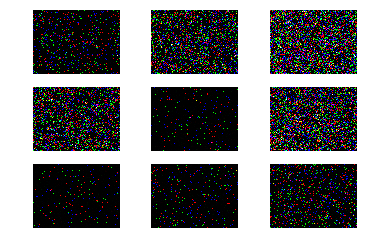

In [26]:
if __name__ == '__main__':
    train(X_train, 200, 4)

In [ ]:
# Load model
model = load_weights

In [27]:
A = np.random.randn(4,3)
B = np.sum(A, axis = 1, keepdims = True)
B.shape

(4, 1)